In [40]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [41]:
df = pd.read_csv("../data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [42]:
# create_date로부터 '월'을 의미하는 month 정보를 피처로 추출합니다.
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력합니다.
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

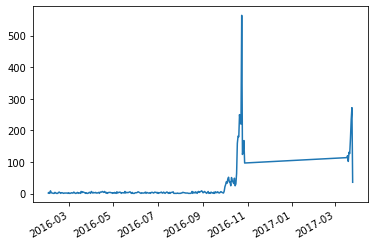

In [43]:
# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
# to_datetime() : 문자를 날짜형식(timestamp)으로 변환
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

<AxesSubplot:>

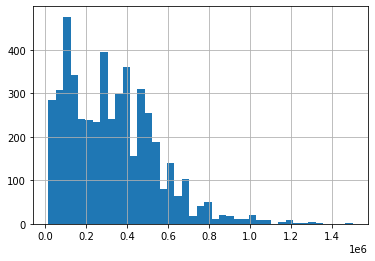

In [44]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")

<AxesSubplot:>

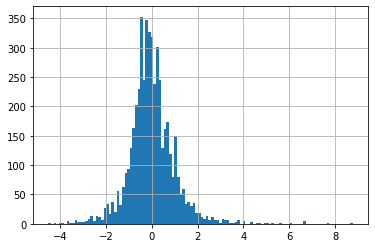

In [45]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표춘편차를 계산합니다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score(표준화 점수)를 계산합니다.
# z-score는 평균값과 얼마나 거리가 먼지 계산해주는 통계적인 예측값이다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

<AxesSubplot:xlabel='factory_price', ylabel='price'>

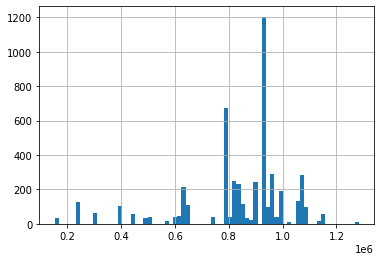

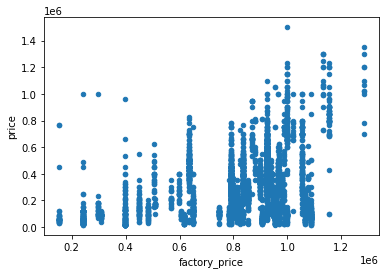

In [46]:
# factory_price 피처의 분포를 탐색합니다.
df['factory_price'].hist(bins="auto")

# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴봅니다.
df.plot.scatter(x='factory_price', y='price')

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x11f722bf340>,
 'caps': [<matplotlib.lines.Line2D at 0x11f722bf5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11f722bf790>],
 'medians': [<matplotlib.lines.Line2D at 0x11f722d8d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x11f722d8b80>],
 'means': []}

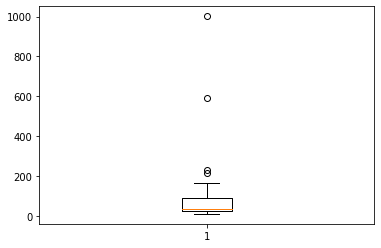

In [47]:
# 기종별 총 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [49]:
# 데이터를 학습/테스트용 데이터로 분리합니다.
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습합니다.
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가합니다.
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                      mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

MSE train: 10625622876.248, test: 13848900083.734
R^2 train: 0.781, test: 0.683


[('factory_price', 0.40484113748092826),
 ('maker_apple', 0.29749198560292783),
 ('phone_model_iphone se 64gb', 0.02214628587933245),
 ('phone_model_galaxy s3 3g 8gb', 0.021967261873270562),
 ('price_index', 0.02023074204894932),
 ('phone_model_galaxy s4 32gb', 0.016108800363746612),
 ('month_2017-03', 0.015040250118518877),
 ('maker_samsung', 0.01423252979146808),
 ('phone_model_galaxy s6 32gb', 0.012471107532472558),
 ('month_2016-05', 0.011149415379955287)]

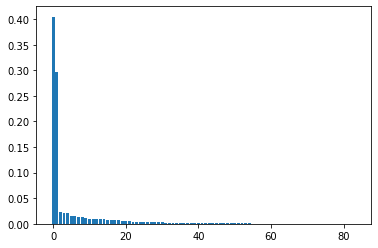

In [50]:
# 학습한 모델의 피처 중요도를 그래프로 살펴봅니다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
# zip() 은 동일한 개수로 이루어진 자료형을 묶어 주는 역할을 하는 함수이다.
feature = list(zip(feat_labels, forest.feature_importances_))
# sorted라는 정렬함수는 시퀀스 자료형 뿐만 아니라 순서에 구애받지 않는 자료형에도 적용할 수 있습니다. 정렬된 결과는 list로 반환됩니다.
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [51]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력합니다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.015040250118518877)
('month_2016-05', 0.011149415379955287)
('month_2016-09', 0.008527001719697922)
('month_2016-04', 0.007537643093787137)
('month_2016-10', 0.006462781155201945)
('month_2016-06', 0.004500203065135738)
('month_2016-08', 0.003661190751785434)
('month_2016-07', 0.002721695294088638)
('month_2016-03', 0.002434850928499713)
('month_2016-02', 0.0010442754305291983)


In [52]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("../data/used_mobile_phone.csv")

In [53]:
from datetime import datetime
import time

In [54]:
# create_date 피처를 수치적으로 계산하기 위해 unixtime으로 변환하는 함수를 정의합니다.
# unixtime : 시간을 정수로 표현한 것이며 값이 클수록 '최근'에 가까워집니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))

# 변환된 unixtime에 min-max 스케일링을 적용합니다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                            (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


In [55]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출합니다.
# split함수는 문자열을 공백 혹은 어떠한 기준으로 나눌때 사용하는 함수이다. 
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'whiskers': [<matplotlib.lines.Line2D at 0x11f005cddf0>,
 'caps': [<matplotlib.lines.Line2D at 0x11f005cd760>,
 'boxes': [<matplotlib.lines.Line2D at 0x11f005cd790>,
 'medians': [<matplotlib.lines.Line2D at 0x11f0173db80>,
 'fliers': [<matplotlib.lines.Line2D at 0x11f01b6f0d0>,
 'means': []}

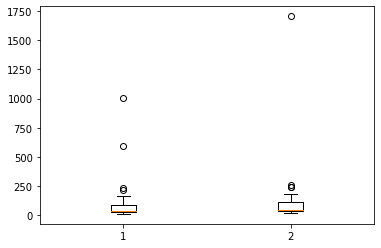

In [56]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계합니다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처 간의 기종별 거래 데이터 개수를 비교합니다.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

-1.3966616903783375
1.666982156397844


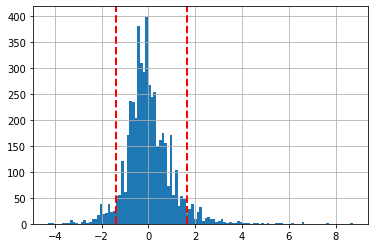

In [58]:
# 거래 가격(price)의; z-score를 계산합니다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
# std() : 표준편차
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력합니다.
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound라고 지정합니다.
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가합니다.
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound, upper_bound를 출력합니다.
print(lower_bound)
print(upper_bound)